
<img src="https://raw.githubusercontent.com/archivesunleashed/archivesunleashed.org/master/themes/hugo-material-docs/static/images/logo-square.png" height="100px" width="100px">


# Welcome

Welcome to the Archives Unleashed Cloud Jupyter Notebook. This demonstration takes the main derivatives from the Cloud and uses Python to analyze and produce information about your collection.

Please feel free to create an [issue](https://github.com/archivesunleashed/auk/issues) to let us know about any bugs you encountered or improvements you would like to see.

If you have Python experience, please feel free to change the provided code to suit your own needs.

We recommend that you use `File > Make a Copy` first before changing the code in the repository. That way, you can always return to the basic visualizations we have offered here. Of course, you can also just re-download the Jupyter Notebook file from your Archives Unleashed Cloud account.

### How Jupyter Notebooks Work

If you have no previous experience with Jupyter Notebooks, the most important thing to understand is that that `<Shift> + <Enter/Return>` will run the Python code inside a cell and output it to below the cell.
    
The cells that cover the required inputs, marked "Setup", need to be run before the rest of the notebook will work. These cells will import all the libraries and set basic variables (e.g. where your derivative files are located) for the notebook. After that, everything else should be able to run on its own.

If you just want to see all results for your collection, use `Cell > Run All`.


# Setup

## The Collection ID

This variable is the most important, and the only variable you need to change to see a complete set of visualizations for your [Archives Unleashed Cloud derivatives](https://cloud.archivesunleashed.org/derivatives).

In [86]:
COLLECTION_ID = "4867" # Change to switch collections.

Using the collection id, the rest of the variables will be set up here. Also, some libraries like [pandas](https://pandas.pydata.org/), [numpy](http://www.numpy.org/), [networkx](https://networkx.github.io/), and [nltk](https://www.nltk.org/) will be imported so you can do the analysis.

In [88]:
# Required packages.

from collections import Counter
import logging
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.draw.dispersion import dispersion_plot as dp
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

# Setup Archives Unleashed Cloud data.

auk_fp = "./data/"
auk_full_text = auk_fp + COLLECTION_ID + "-fulltext.txt"
auk_gephi = auk_fp + COLLECTION_ID + "-gephi.gexf"
auk_graphml = auk_fp + COLLECTION_ID + "-gephi.graphml"
auk_domains = auk_fp + COLLECTION_ID + "-fullurls.txt"
auk_filtered_text = auk_fp + COLLECTION_ID + "-filtered_text.zip"

## User Configuration

The following cell sets out some user-generated variables. Take a look here: are there any domains you are not interested in? How many words would you like to be shown? Do you want to filter out 404 results? Do you want to sample the data? Read the choices below carefully.

In [90]:
# Maximum number of words to show in output.
# Jupyter will create an output error if the number is too high.

TOP_COUNT = 30 

# Domain suffixes to check non-U.S. domains so that (e.g.) www.google.co.uk will become "google".

STOP_DOMAINS = ["co", "org", "net", "edu"] # Domain suffixes to remove.

# Minimum number of characters for a word to be included in a corpus.

MINIMUM_WORD_LENGTH = 3 # Eliminates "it", "I", "be" etc.

# List of substrings to filter a text line, if desired.

LINE_FILTER = ['404 Not Found']

# How many lines of text to use.

RESULTS_LIMIT = 2500

# If you want to start at a different line, you can increase this.
# If RESULTS_START is great than RESULTS_LIMIT you will get no results.

RESULTS_START = 0

# If you have a large file but want to sample the file more broadly.
# You can increase this value skip to every Nth line.

RESULTS_STEP = 5

# Change if you want a different filename.

OUTPUT_FILENAME = "./filtered_text.txt" # Filename if you want to output to another file.

# Characters to show per text file in output.
# Larger numbers will result in more text showing in output.

MAX_CHARACTERS = 75

# The years to include in the analysis.
# If empty, you will get all available years.

FILTERED_YEARS = [] # E.g. ['2015', '2016', '2019'].

# The domains to include in the analysis.
# If empty, you will get all available domains.

FILTERED_DOMAINS = [] # E.g ["google", "apple", "facebook"].

# List of words not to include in a corpus for text analysis.

STOP_WORDS = set(stopwords.words('english'))

## Archives Unleashed Cloud Python Library

The cell below now sets up the functions that drive the analysis throughout this notebook. If you don't run it, you won't be able to work with the data. 

In [92]:
def clean_domain(s):
    """Extracts the name from the domain (e.g. 'www.google.com' becomes 'google').
    
    :param: s: The domain name to clean.
    :return: The relevant name.
    """
    
    ret = ""
    dom = s.split(".")
    if len(dom) <3: # x.com is always x.
        ret = dom[0]
    elif dom[-2] in STOP_DOMAINS: # www.x.co.uk should be x.
        ret = dom[-3]
    else:
        ret = dom[1]
    return ret

def get_domains(split_method="full"):
    """Extracts the domains from a file by method.
    
    :param split_method: Either "full" "name" or "sub". "name" provides just the domain name, 
         "sub" produces the name with subdomains. "full" provides the entire name. 
    :return: A list of tuples containing (urlname, count).
    """
    
    ret = []
    with open(auk_domains) as fin:
        for line in fin:
            ret.append(line.strip('()\n').split(","))
    if split_method == 'name':
        scores = Counter()
        for url, count in ret:
            scores.update({clean_domain(url): int(count)})
        ret = scores
    elif split_method == 'sub':
        scores = Counter()
        splits = [(x[0].split('.'), int(x[1])) for x in ret]
        for url, count in splits:
            if len(url) < 3:
                scores.update({'.'.join(['www', url[0]]) : count})
            else:
                scores.update({ '.'.join([url[0], url[1]]) : count})
        ret = scores
    else:
        scores = Counter()
        for url, count in ret:
            scores.update({url: int(count)})
        ret = scores
    return ret

def get_text(by="all", minline=MINIMUM_WORD_LENGTH):
    """Get the text from the files (by domain or year if desired).
    
    :param by: "all", "domain" or "year" the output to return.
    :param minline: The minimum size of a line to be included in the output.
    :return: [({year or domain}, textString)] if by is 'domain' or 'year', otherwise [textString].
    """
    
    text = []
    form = range(RESULTS_START, RESULTS_LIMIT, RESULTS_STEP)
    with open(auk_full_text) as fin:
        for num in range(RESULTS_LIMIT):
            if num in form:
                line = next(fin)
                split_line = str(line).split(",", 3)
                if (len(split_line[3]) >= MINIMUM_WORD_LENGTH and set([split_line[3].find(x) for x in LINE_FILTER]) == {-1}):   
                    if by == "domain": 
                        text.append((clean_domain(split_line[1]), split_line[3]))
                    elif by == "year":
                        text.append((split_line[0][1:5], split_line[3]))
                    else:
                        text.append(split_line[3])
            else:
                next(fin)                   
    return text

def get_text_tokens (minlen=MINIMUM_WORD_LENGTH) :
    """Get the data and tokenize the text.
    
    :param minlen: The minimum word size to be included in the list of words.
    :return: A list of words included in the text file.
    """
    
    return [x.lower() for x in word_tokenize(' '.join(get_text())) if len(x) > minlen]

def get_tokens_domains(minlen=MINIMUM_WORD_LENGTH):
    """Get tokens by domain.
    
    :param minlen: The minimum word size to be included in the list of words.
    :return: A list of tuples with (domain, Counter).
    """
    
    return [(x[0], Counter([y for y in word_tokenize(x[1]) if len(y) > minlen])) for x in get_text("domain")]

def get_tokens_years(minlen=MINIMUM_WORD_LENGTH):
    """Get tokens by year.
    
    :para minlen: The minimum word size to be included in the list of words.
    :return: A list of tuples with (year, Counter).
    """
    
    return [(x[0], Counter([y for y in word_tokenize(x[1]) if len(y) > minlen])) for x in get_text("year")]
    

def year(minlen=MINIMUM_WORD_LENGTH):
    """Used by get_top_tokens_by to get the tokens by year."""
    return get_tokens_years(minlen)

def domain(minlen=MINIMUM_WORD_LENGTH):
    """Used by get_top_tokens_by to get tokens by domain."""
    return get_tokens_domains(minlen)
 
def get_top_tokens(total=TOP_COUNT, minlen=MINIMUM_WORD_LENGTH):
    """Return the top tokens for the text."""
    return [(key, value) for key, value in Counter(get_text_tokens(minlen)).most_common(total)]

def get_top_tokens_by(fun, total=TOP_COUNT, minlen=MINIMUM_WORD_LENGTH):
    """ Get the top tokens by a function.
    
    :para fun: A function that returns a list of (key, Counter([tokenized_list])).
    :para total: The number of top tokens to return for each key.
    :para minlen: The minimum word length.
    :return: A list of minlen tokens by fun.
    """
    
    sep = dict()
    tokens = fun(minlen)
    sep = {k[0]: Counter() for k in tokens}
    for key, value in tokens:
        sep[key] += value
    ret = [(key, val.most_common(total)) for key, val in sep.items()]
    return (ret)


def international(text):
    """Applies UTF-16 if possible.
    
    :param text: The text to decode (assumes UTF-8).
    :return: UTF-32 or UTF-16 decoded string or else original string.
    """
    
    unicode = text.encode("utf-8")
    try:
        ret = unicode.decode("UTF-32-LE")
    except UnicodeDecodeError:
        try:
            ret = unicode.decode("UTF-32-BE")
        except UnicodeDecodeError:
            try: 
                ret = unicode.decode("UTF-16-LE")
            except UnicodeDecodeError:
                try: 
                    ret = unicode.decode("UTF-16-BE")
                except UnicodeDecodeError:
                    ret = unicode.decode("UTF-8")
            
    return ret

def write_output (stdout, results):
    """ Writes results to file.
    
    :param stdout: Filepath for file.
    :param results: A list of results.
    :return: None.
    """
    
    try:
        with open(filename, "w") as output:
            for value in results:
                output_file_write(str(value))
    except:
        print("Error writing the file.")
        
def sentiment_scores(by="domain"):
    """ Calculates sentiment scores for a body of text.
    
    :param by: Either "year" or "domain".
    :return: A list of tuples with (year/domain, ("neg", score), ("neu", score) etc.).
    """
    
    sep = dict()
    corpus = get_text(by)
    sep = {k[0]: [] for k in corpus}
    for key, value in corpus:
        sep[key] += sent_tokenize(value)
    sid = SentimentIntensityAnalyzer()
    result = []
    for a, b in sep.items():
        scores = Counter({"neg": 0, "pos":0, "neu":0, "compound":0})
        for c in b:
            scores.update(sid.polarity_scores(c))
        result += [(a, ("neg", scores['neg']/len(b)), ("pos", scores['neg']/len(b)), ("neu", scores['neu']/len(b)), ("compound", scores['compound']/len(b)))]
 
    return(result)

# Basic Analysis of Domains

Domains data provides basic information about what is crawled and how often. Change the variables in the following cell to manipulate the domain analysis. For example, you may want to exclude common domains (i.e. "google") or you may be interested in sub-domains such as ca.geocities.com.

In [94]:
DOMAIN_BY = 'name' # Change to 'sub' if you want to include subdomains.
DOMAIN_EXCLUDE = ['google', 'facebook', 'youtube', 'apple'] # Add items to this list to exclude from the collection.
DOMAIN_FIGURE_SIZE = [10, 4] # Change the width and height of your graph plot ([wdth, hgt]).
DOMAIN_RESULTS = 30 # The number of results to plot.
DOMAIN_BAR_WIDTH = 0.35 # The width of the bars in the histogram.
DOMAIN_Y_LABEL = "Number of occurences." # The label for the y axis.
DOMAIN_TITLE = "Top domains by count." # The title of the graph.

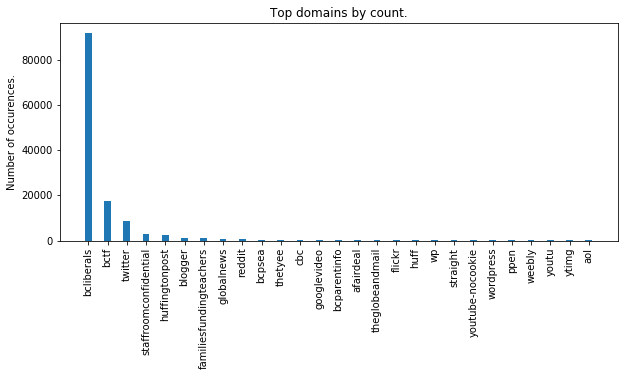

In [96]:
# Count the times a domain appears and count it.

plt.rcParams['figure.figsize'] = DOMAIN_FIGURE_SIZE # Set the figure size for the graph.
domains = get_domains(DOMAIN_BY).most_common(DOMAIN_RESULTS) 
vals = [x[1] for x in domains if x[0] not in DOMAIN_EXCLUDE]
labs = [x[0] for x in domains if x[0] not in DOMAIN_EXCLUDE]
ind = np.arange(len(vals))
width = DOMAIN_BAR_WIDTH
p1 = plt.bar(ind, vals, width)
plt.ylabel(DOMAIN_Y_LABEL)
plt.title(DOMAIN_TITLE)
plt.xticks(ind, labs, rotation='vertical')
plt.show()

As the domain derivative is relatively straightforward, there is not much else that we do with it. 

# Text Analysis

The following set of functions use the [Natural Language Toolkit](https://www.nltk.org) Python library to identify the most frequently used words in the collection, as well as facilitate breaking it down by name or domain. 

### Text by Year

Change the variables in the following cell to manipulate the text analysis. For example, you may want to do your analysis by year, or you may be interested in analyzing text by domain (or both). You may also want to see more results than the default that we provide.


In [98]:
TEXT_METHOD = 'year' # Choose "year", "domain", or "all".
TEXT_OUTPUT_FILENAME = '' # Change this if want a custom filename, otherwise, OUTPUT_FILENAME will be used.
TEXT_INTERNATIONAL = True # Change to False if you want only UTF-8 characters.
TEXT_OUTPUT_SIZE = 10 # Change to increase or decrease the number of results shown.

In [100]:
# Get the set of available years in the collection.

year_range = set([x[0] for x in get_text(TEXT_METHOD)])
print(year_range)

{'2014'}


Now we can create separate lists with text files from individual years in this collection. You can add years (e.g. "2019") to `FILTERED_YEARS` in to limit your results.

In [102]:
# Get and print the first n lines of text.

filename = TEXT_OUTPUT_FILENAME if (TEXT_OUTPUT_FILENAME) else OUTPUT_FILENAME
year_filter = FILTERED_YEARS if FILTERED_YEARS else year_range # Add or remove years for filter.
year_results = [t[1] for t in get_text(TEXT_METHOD) if t[0] in list(year_filter)]
     
# Some of the text may be in an international font.

for i in year_results[:TEXT_OUTPUT_SIZE]:
    print (international(i)[:MAX_CHARACTERS] if (TEXT_INTERNATIONAL) else i[:MAX_CHARACTERS])

## Removing the # on the following line will write the results to TEXT_OUTPUT_FILENAME if set, 
## or OUTPUT_FILENAME (set in the User Configuration section).

#write_output(filename, year_results)

慎浯⁩慙慭潭潴映牯丠牯桴嘠湡潣癵牥䰭湯摳污⁥‭䱍獁簠吠摯祡猧䈠⁃楌敢慲獬䈠⁃楌敢慲獬䠠浯⁥牐浥敩⁲敔浡传牵倠牡祴䈠⁃楌敢慲⁬䱍獁䈠⁃潙湵⁧楌敢慲獬圠浯
Jane Thornthwaite for North Vancouver-Seymour - MLAs | Today's BC Liberals 
Lesli Boldt on Twitter: "Gov’t resistance to mediator suggests lack of will
BCTF on Twitter: "With funding $1000 below the national average, #bced stud
敔捡敨⁲敮獷慭慧楺敮†汃獯⁥楗摮睯倠楲瑮倠条⁥䍂吠慥档牥❳䘠摥牥瑡潩⁮潈敭㸠倠扵楬慣楴湯⁳‾敔捡敨⁲敎獷慭⁧‾牁档癩獥㸠䨠湡⼮敆⹢㈠㄰‴敔捡敨⁲敎獷慭
CBC Vancouver - Granville & 49th fire broke out at... | Facebook Facebook l
慌牵敩吠牨湯獥⁳潦⁲桃汩楬慷正䠭灯⁥‭䱍獁簠吠摯祡猧䈠⁃楌敢慲獬䈠⁃楌敢慲獬䠠浯⁥牐浥敩⁲敔浡传牵倠牡祴䈠⁃楌敢慲⁬䱍獁䈠⁃潙湵⁧楌敢慲獬圠浯湥胢玙丠
䍂䰠扩牥污吠慥⁭潦⁲牂瑩獩⁨潃畬扭慩ⴠ䴠䅌⁳⁼潔慤❹⁳䍂䰠扩牥污⁳䍂䰠扩牥污⁳潈敭倠敲業牥吠慥⁭畏⁲慐瑲⁹䍂䰠扩牥污䴠䅌⁳䍂夠畯杮䰠扩牥污⁳潗敭馀⁳
桔⁥祔敥鎀丠瑯圠慨⁴潙⁵敗敲䰠潯楫杮䘠牯䄠潢瑵䄠癤牥楴敳䘠汯潬⁷畓灰牯⁴卒⁓潔楰⁣扁牯杩湩污䄠晦楡獲䈠⁃汅捥楴湯㈠㄰″䍂倠汯瑩捩⁳摅捵瑡潩⁮湅牥祧䔠
Teacher newsmagazine  Close Window Print Page BC Teachers' Federation Home 


### Text by Domain

In [104]:
# Get the set of available domains in the collection.

domain_set = set([x[0] for x in get_text("domain")])
print(domain_set)

{'patch', 'facebook', 'huffingtonpost', 'youtube', 'radioreddit', 'blogger', 'huff', 'bctf', 'thetyee', 'google', 'staffroomconfidential', 'twitter', 'familiesfundingteachers', 'cbc', 'bcliberals', 'reddit', 'betterschoolsbc'}


Change the variables in the following cell to restrict the text output to include only the text from the websites with those domain names.

In [106]:
TEXT_SELECT_DOMAINS = [] # Restrict text extraction to these domains.

In [108]:
# Extract only the given domain to a file and see how many results there are.

domain_set = FILTERED_DOMAINS if FILTERED_DOMAINS else domain_set
domain_set = TEXT_SELECT_DOMAINS if TEXT_SELECT_DOMAINS else domain_set
domain_results = [t[1] for t in get_text("domain") if t[0] in domain_set]
print("****Total files****:" + str(len(domain_results)) + "\n")
print("****Sample results****: \n")
for samp in domain_results[:TEXT_OUTPUT_SIZE]:
    if len(samp) > 4:
        print(international(samp)[:MAX_CHARACTERS] + " \n")

****Total files****:253

****Sample results****: 

慎浯⁩慙慭潭潴映牯丠牯桴嘠湡潣癵牥䰭湯摳污⁥‭䱍獁簠吠摯祡猧䈠⁃楌敢慲獬䈠⁃楌敢慲獬䠠浯⁥牐浥敩⁲敔浡传牵倠牡祴䈠⁃楌敢慲⁬䱍獁䈠⁃潙湵⁧楌敢慲獬圠浯 

Jane Thornthwaite for North Vancouver-Seymour - MLAs | Today's BC Liberals  

Lesli Boldt on Twitter: "Gov’t resistance to mediator suggests lack of will 

BCTF on Twitter: "With funding $1000 below the national average, #bced stud 

敔捡敨⁲敮獷慭慧楺敮†汃獯⁥楗摮睯倠楲瑮倠条⁥䍂吠慥档牥❳䘠摥牥瑡潩⁮潈敭㸠倠扵楬慣楴湯⁳‾敔捡敨⁲敎獷慭⁧‾牁档癩獥㸠䨠湡⼮敆⹢㈠㄰‴敔捡敨⁲敎獷慭 

CBC Vancouver - Granville & 49th fire broke out at... | Facebook Facebook l 

慌牵敩吠牨湯獥⁳潦⁲桃汩楬慷正䠭灯⁥‭䱍獁簠吠摯祡猧䈠⁃楌敢慲獬䈠⁃楌敢慲獬䠠浯⁥牐浥敩⁲敔浡传牵倠牡祴䈠⁃楌敢慲⁬䱍獁䈠⁃潙湵⁧楌敢慲獬圠浯湥胢玙丠 

䍂䰠扩牥污吠慥⁭潦⁲牂瑩獩⁨潃畬扭慩ⴠ䴠䅌⁳⁼潔慤❹⁳䍂䰠扩牥污⁳䍂䰠扩牥污⁳潈敭倠敲業牥吠慥⁭畏⁲慐瑲⁹䍂䰠扩牥污䴠䅌⁳䍂夠畯杮䰠扩牥污⁳潗敭馀⁳ 

桔⁥祔敥鎀丠瑯圠慨⁴潙⁵敗敲䰠潯楫杮䘠牯䄠潢瑵䄠癤牥楴敳䘠汯潬⁷畓灰牯⁴卒⁓潔楰⁣扁牯杩湩污䄠晦楡獲䈠⁃汅捥楴湯㈠㄰″䍂倠汯瑩捩⁳摅捵瑡潩⁮湅牥祧䔠 

Teacher newsmagazine  Close Window Print Page BC Teachers' Federation Home  



## Overall Collection Characteristics

Change the variables in the following cell to manipulate the analysis you'll be running to understand overall collection characteristics. In this case, they mostly affect the visualization that we generate.


In [110]:
OVERALL_OUTPUT_SIZE = 20 # Size of output to show.
OVERALL_BAR_WIDTH = 0.35 # The size of the bars in the histogram.
OVERALL_Y_LABEL = "Number of occurences." # The Y axis label.
OVERALL_TITLE = 'Top words by count.' # The plot title.
OVERALL_SHOW_TOKENS = 3 # The number of top words to show.

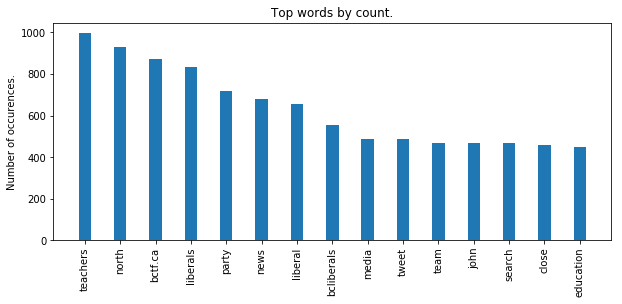

In [112]:
# Get a list of the top words in the collection (regardless of year).

tokens = get_top_tokens()[:OVERALL_OUTPUT_SIZE]
vals = [x[1] for x in tokens if x[0] not in STOP_WORDS]
labs = [x[0] for x in tokens if x[0] not in STOP_WORDS]
ind = np.arange(len(vals))    # The x locations for the groups.
width = OVERALL_BAR_WIDTH       # The width of the bars: can also be len(x) sequence.
p1 = plt.bar(ind, vals, width)
plt.ylabel(OVERALL_Y_LABEL)
plt.title(OVERALL_TITLE)
plt.xticks(ind, labs, rotation='vertical')
plt.show()

In [114]:
# Get a list of the top tokens, separated by year.

get_top_tokens_by(year, OVERALL_SHOW_TOKENS)[0:OVERALL_OUTPUT_SIZE]

[('2014', [('North', 928), ('bctf.ca', 871), ('Liberals', 833)])]

In [116]:
# Get a list of top tokens, separated by domain.

get_top_tokens_by(domain, OVERALL_SHOW_TOKENS)[0:OVERALL_OUTPUT_SIZE]

[('bcliberals', [('North', 886), ('Liberals', 827), ('Party', 711)]),
 ('twitter', [('Close', 421), ('Tweet', 330), ('Twitter', 275)]),
 ('bctf', [('bctf.ca', 870), ('Teachers', 602), ('that', 460)]),
 ('facebook', [('Facebook', 35), ('Create', 16), ('your', 14)]),
 ('thetyee', [('Tyee', 43), ('curriculum', 30), ('comments', 22)]),
 ('huffingtonpost', [('Alberta', 73), ('More', 40), ('Images', 39)]),
 ('cbc', [('Menu', 16), ('page', 10), ('Radio', 8)]),
 ('google', [('your', 84), ('news', 66), ('News', 60)]),
 ('staffroomconfidential', [('that', 71), ('this', 47), ('school', 44)]),
 ('reddit', [('submitted', 51), ('sharecancel', 51), ('loading', 51)]),
 ('blogger', [('Moved', 6), ('Blogger', 4), ('Temporarily', 4)]),
 ('youtube',
  [('Loading', 14), ('SubscribeSubscribedUnsubscribe', 14), ('Watch', 10)]),
 ('betterschoolsbc', [('Norton', 17), ('Internet', 8), ('Security', 8)]),
 ('radioreddit', [('reddit', 4), ('radio', 3), ('music', 3)]),
 ('familiesfundingteachers',
  [('29-Aug-2014'

In [118]:
# Add or remove words to see their location in the output.

DISPERSION_PLOT_WORDS = ['he', 'she'] 

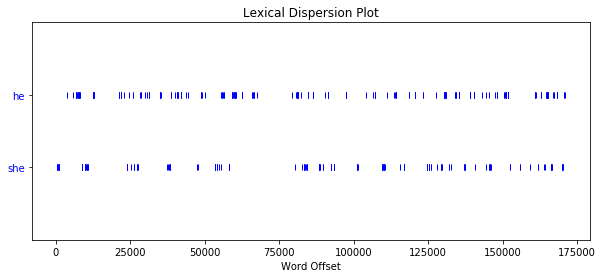

In [120]:
# Create a dispersion plot, showing where the list of words appear in the text.

text = get_text_tokens(1) # Need to have one to include words with fewer than 3 letters.
dp(text, DISPERSION_PLOT_WORDS) # Uses the nltk dispersion plot library (dp).

In [122]:
SENTIMENT_Y_LABEL = "Scores."
SENTIMENT_TITLE = 'Scores by domain and sentiment.'

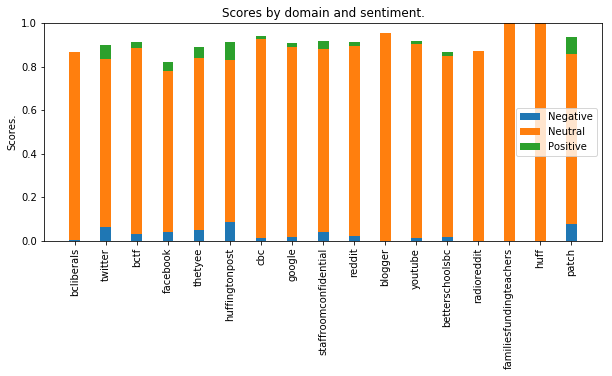

In [124]:
# Collect sentiment scores by domain and visualize them.

sent = sentiment_scores()
N = len(sent)
neg = [x[1][1] for x in sent]
pos = [x[2][1] for x in sent]
neu = [x[3][1] for x in sent]
labs = [x[0] for x in sent]
ind = np.arange(N)    # The x locations for the groups.
width = OVERALL_BAR_WIDTH
p1 = plt.bar(ind, neg, width)
p2 = plt.bar(ind, neu, width,
             bottom=neg)
p3 = plt.bar(ind, pos, width, bottom=neu)
plt.ylabel(SENTIMENT_Y_LABEL)
plt.title(SENTIMENT_TITLE)
plt.xticks(ind, labs, rotation='vertical')
plt.legend((p1[0], p2[0], p3[0]), ('Negative', 'Neutral', 'Positive'))
plt.show()

In [126]:
SENTIMENT_Y_LABEL2 = "Scores."
SENTIMENT_TITLE2 = 'Scores by year and sentiment.'

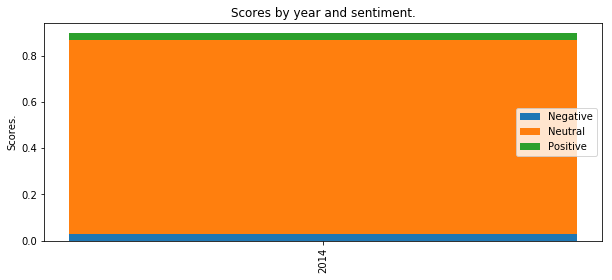

In [128]:
# Collect sentiment scores by year and visualize them.

sent = sentiment_scores("year")
N = len(sent)
neg = [x[1][1] for x in sent]
pos = [x[2][1] for x in sent]
neu = [x[3][1] for x in sent]
labs = sorted([x[0] for x in sent])
ind = np.arange(N)
width = OVERALL_BAR_WIDTH
p1 = plt.bar(ind, neg, width)
p2 = plt.bar(ind, neu, width,
             bottom=neg)
p3 = plt.bar(ind, pos, width, bottom=neu)
plt.ylabel(SENTIMENT_Y_LABEL2)
plt.title(SENTIMENT_TITLE2)
plt.xticks(ind, labs, rotation='vertical')
plt.legend((p1[0], p2[0], p3[0]), ('Negative', 'Neutral', 'Positive'))
plt.show()

# Network Analysis

Sometimes it is useful to include information about the relationships among different websites. We recommend using [Gephi](https://gephi.org/) for graph visualization, but it is possible in this notebook using the Python networkx library as well.

Change the variables in the following cell to manipulate the network analysis that you will be carrying out. Some of these relate to the size of the output, the labels on the graph, and also any domains you might want to exclude from your analysis.

In [130]:
NETWORK_PLOT_FIGURE_SIZE = [10, 4] # Set the figure for the graph.
NETWORK_EXCLUDE = ["google.com"] # Add / Remove urls if you want them out of the analysis.
NETWORK_Y_LABEL = 'Degree'
NETWORK_TITLE = 'Domains by degree.'

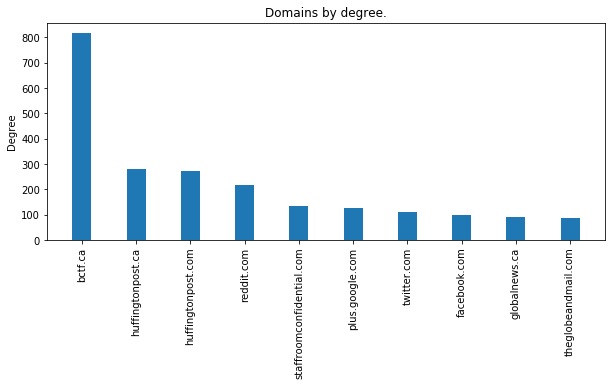

In [132]:
# Degree distribution of domains.

plt.rcParams['figure.figsize'] = NETWORK_PLOT_FIGURE_SIZE # Set the figure size for the graph.
graph = nx.read_gexf(auk_gephi) # Import the graph.
g_nodes = zip([x[1] for x in graph.nodes('label')], [x[1] for x in graph.nodes('Degree')])
gs = sorted([x for x in g_nodes], key=lambda s: s[1], reverse=True)
vals = [x[1] for x in gs if x[0] not in NETWORK_EXCLUDE][:10]
labs = [x[0] for x in gs if x[0] not in NETWORK_EXCLUDE][:10]
ind = np.arange(len(vals))
width = OVERALL_BAR_WIDTH
p1 = plt.bar(ind, vals, width)
plt.ylabel(NETWORK_Y_LABEL)
plt.title(NETWORK_TITLE)
plt.xticks(ind, labs, rotation='vertical')
plt.show()

Change the variables in the following cell to manipulate the visualization that you're about to generate. Do you want the network diagram to be bigger or smaller? Do nodes need to shrink or grow? Are the labels too big or too small? You may need to experiment with the values a bit.

In [134]:
NETWORK_GRAPH_FIGURE_SIZE = [25, 25] # Change the size of the plot.
NETWORK_NODE_SIZE = 100 # Increase or decrease the node size for the graph.
NETWORK_FONT_SIZE = 10 # Increase or decrease the font size for the graph.
NETWORK_SHOW_LABELS = True # Change to False if you do not want to see the labels.

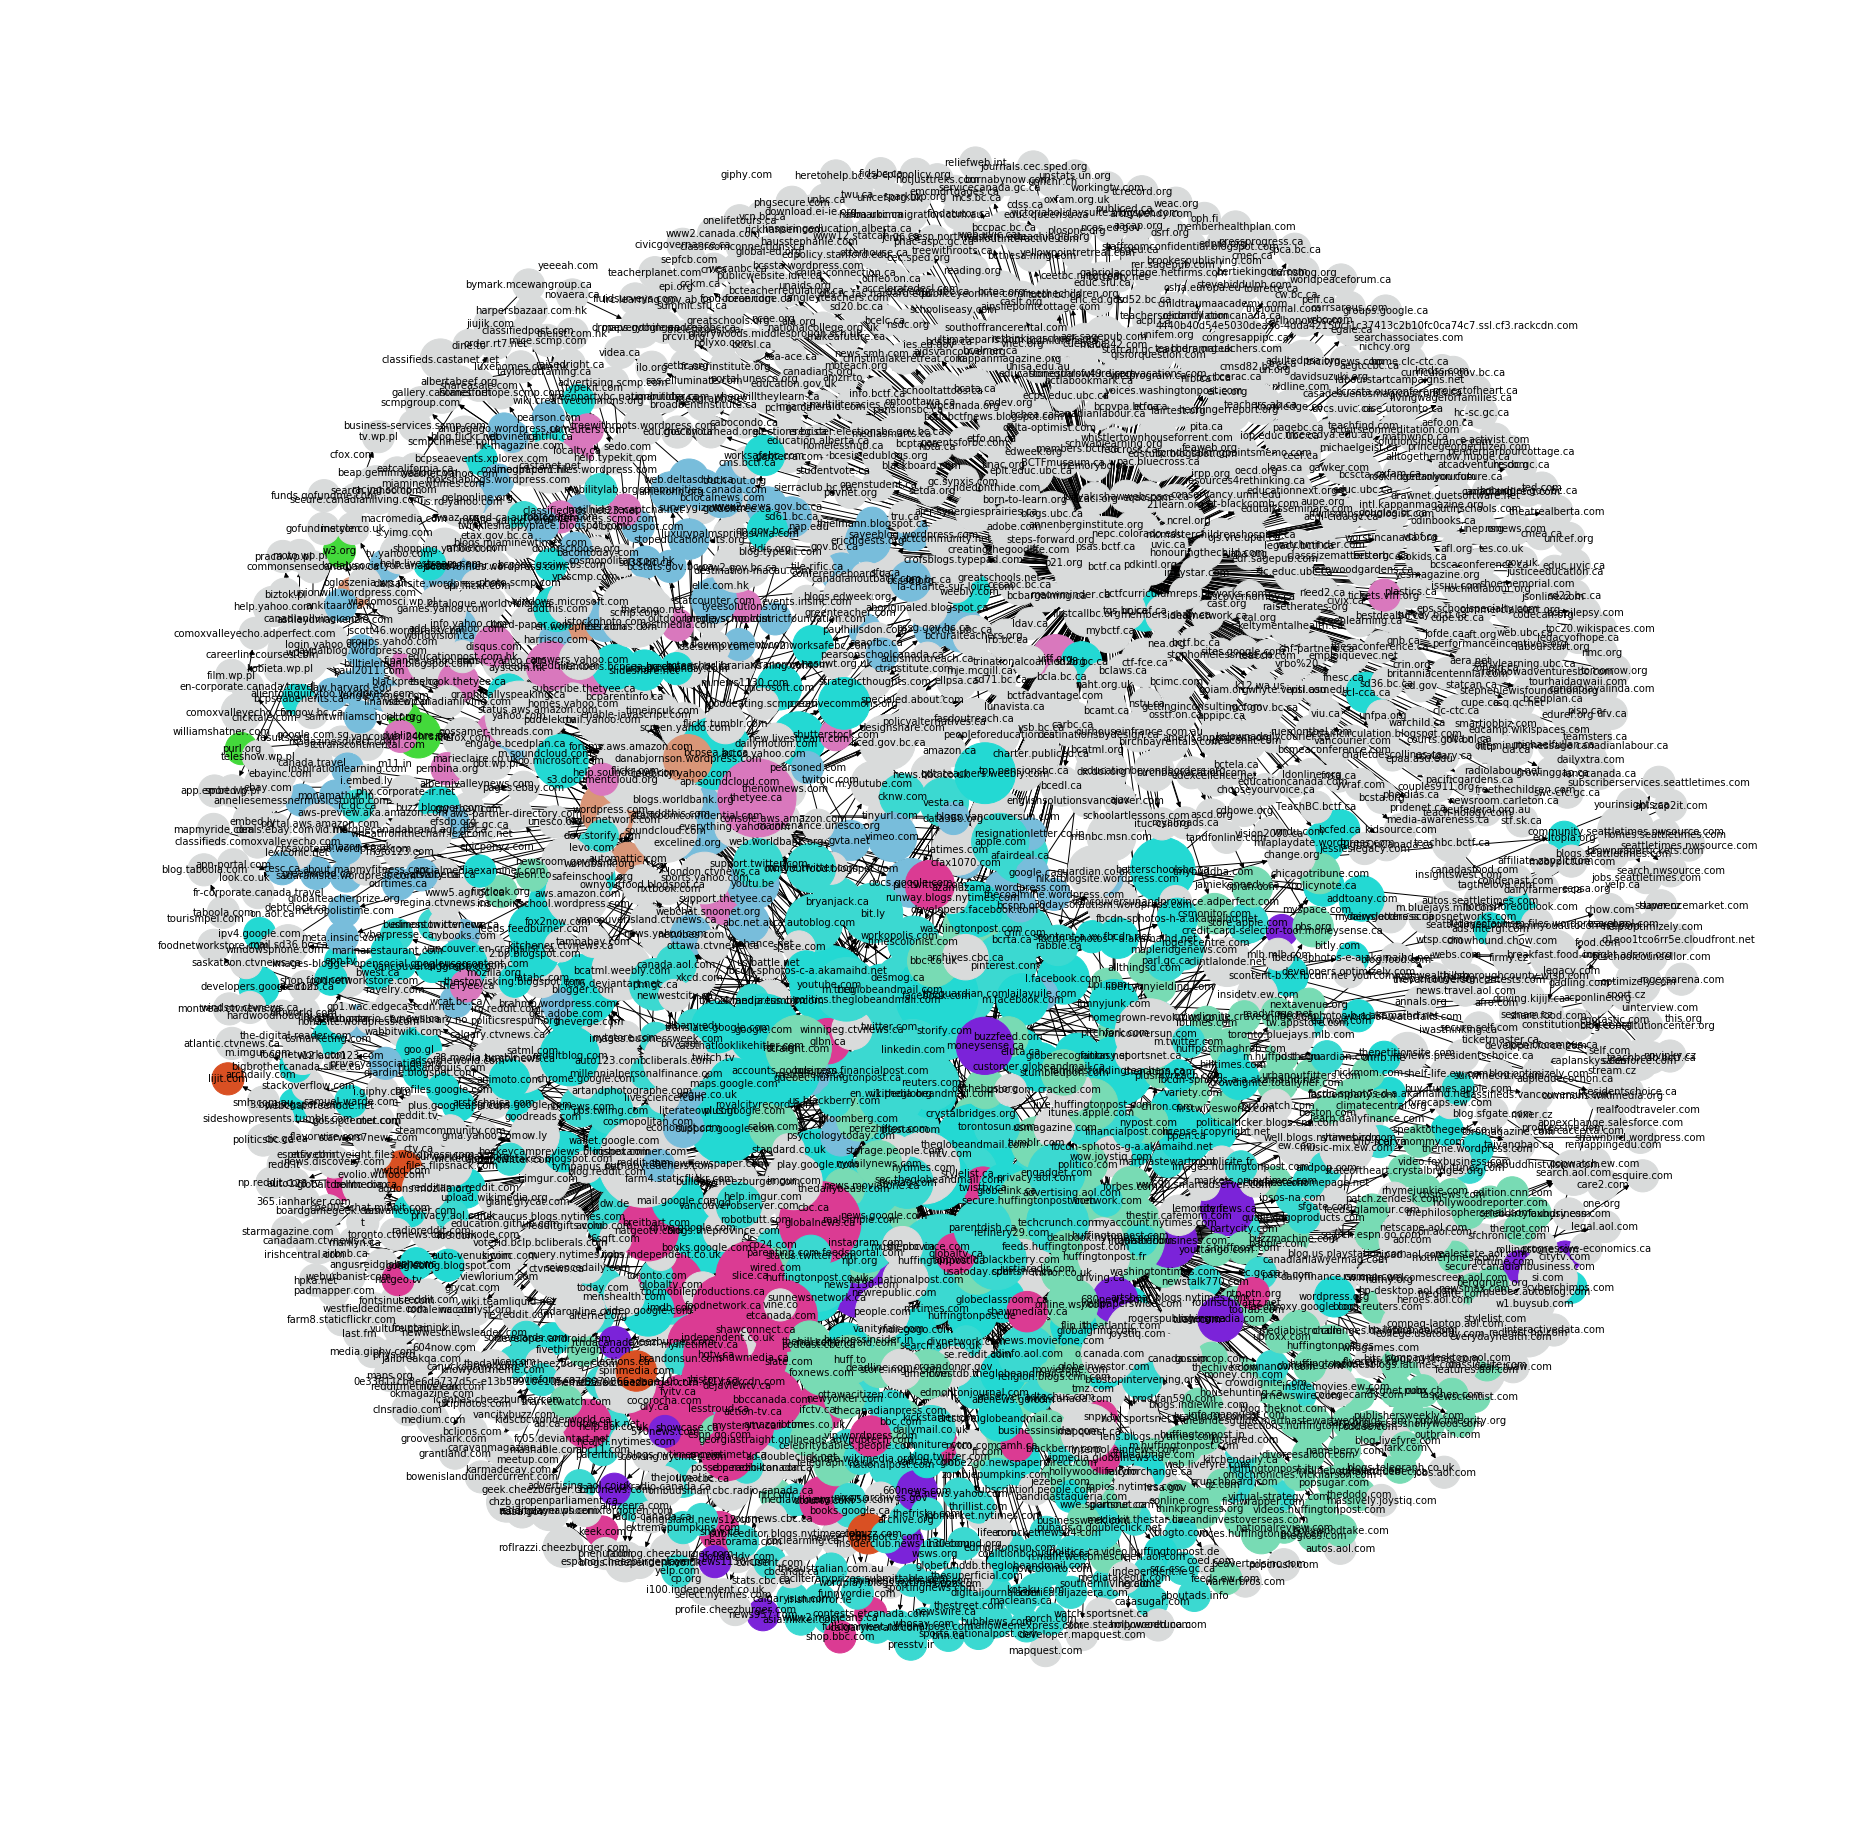

In [136]:
# Network graph.

plt.rcParams['figure.figsize'] = NETWORK_GRAPH_FIGURE_SIZE

# Convert rgb values to between 0 & 1 and put them into a numpy array.

rgbs = zip([x[1]/255 for x in graph.nodes('r')], 
           [x[1]/255 for x in graph.nodes('g')], 
           [x[1]/255 for x in graph.nodes('b')])
colormap = [np.array(x) for x in rgbs]

# Labels.

mapping = {x[0]: x[1] for x in graph.nodes('label')}

# Use Archive Unleashed Clouds positions (saves on load time).

zippos = zip(graph.nodes, [x[1] for x in graph.nodes('x')], [x[1] for x in graph.nodes('y')])
positions = {x[0]: np.array([x[1],x[2]]) for x in zippos}

# Node sizes based on degree.

size = np.array([x[1] * NETWORK_NODE_SIZE for x in graph.nodes('size')])

# Draw the graph.

nx.draw(graph, pos=positions, show_labels=NETWORK_SHOW_LABELS, 
        labels=mapping, font_size=NETWORK_FONT_SIZE, 
        node_size=size, node_color=colormap)
plt.show()

Change the variables in the following cell to manipulate the visualization that you are about to generate. What node do you want the diagram to focus on? The biggest one? Or a specific one?

In [138]:
NETWORK_EGO_NODE_ORDINAL = 0 # Selects the largest node (by degree). Use `1` for 2nd largest,`2` for third largest etc.
NETWORK_EGO_NODE_SPECIFIC = '' # Change to a non-signed node id (eg. 'n20') if you want to select a particular node.

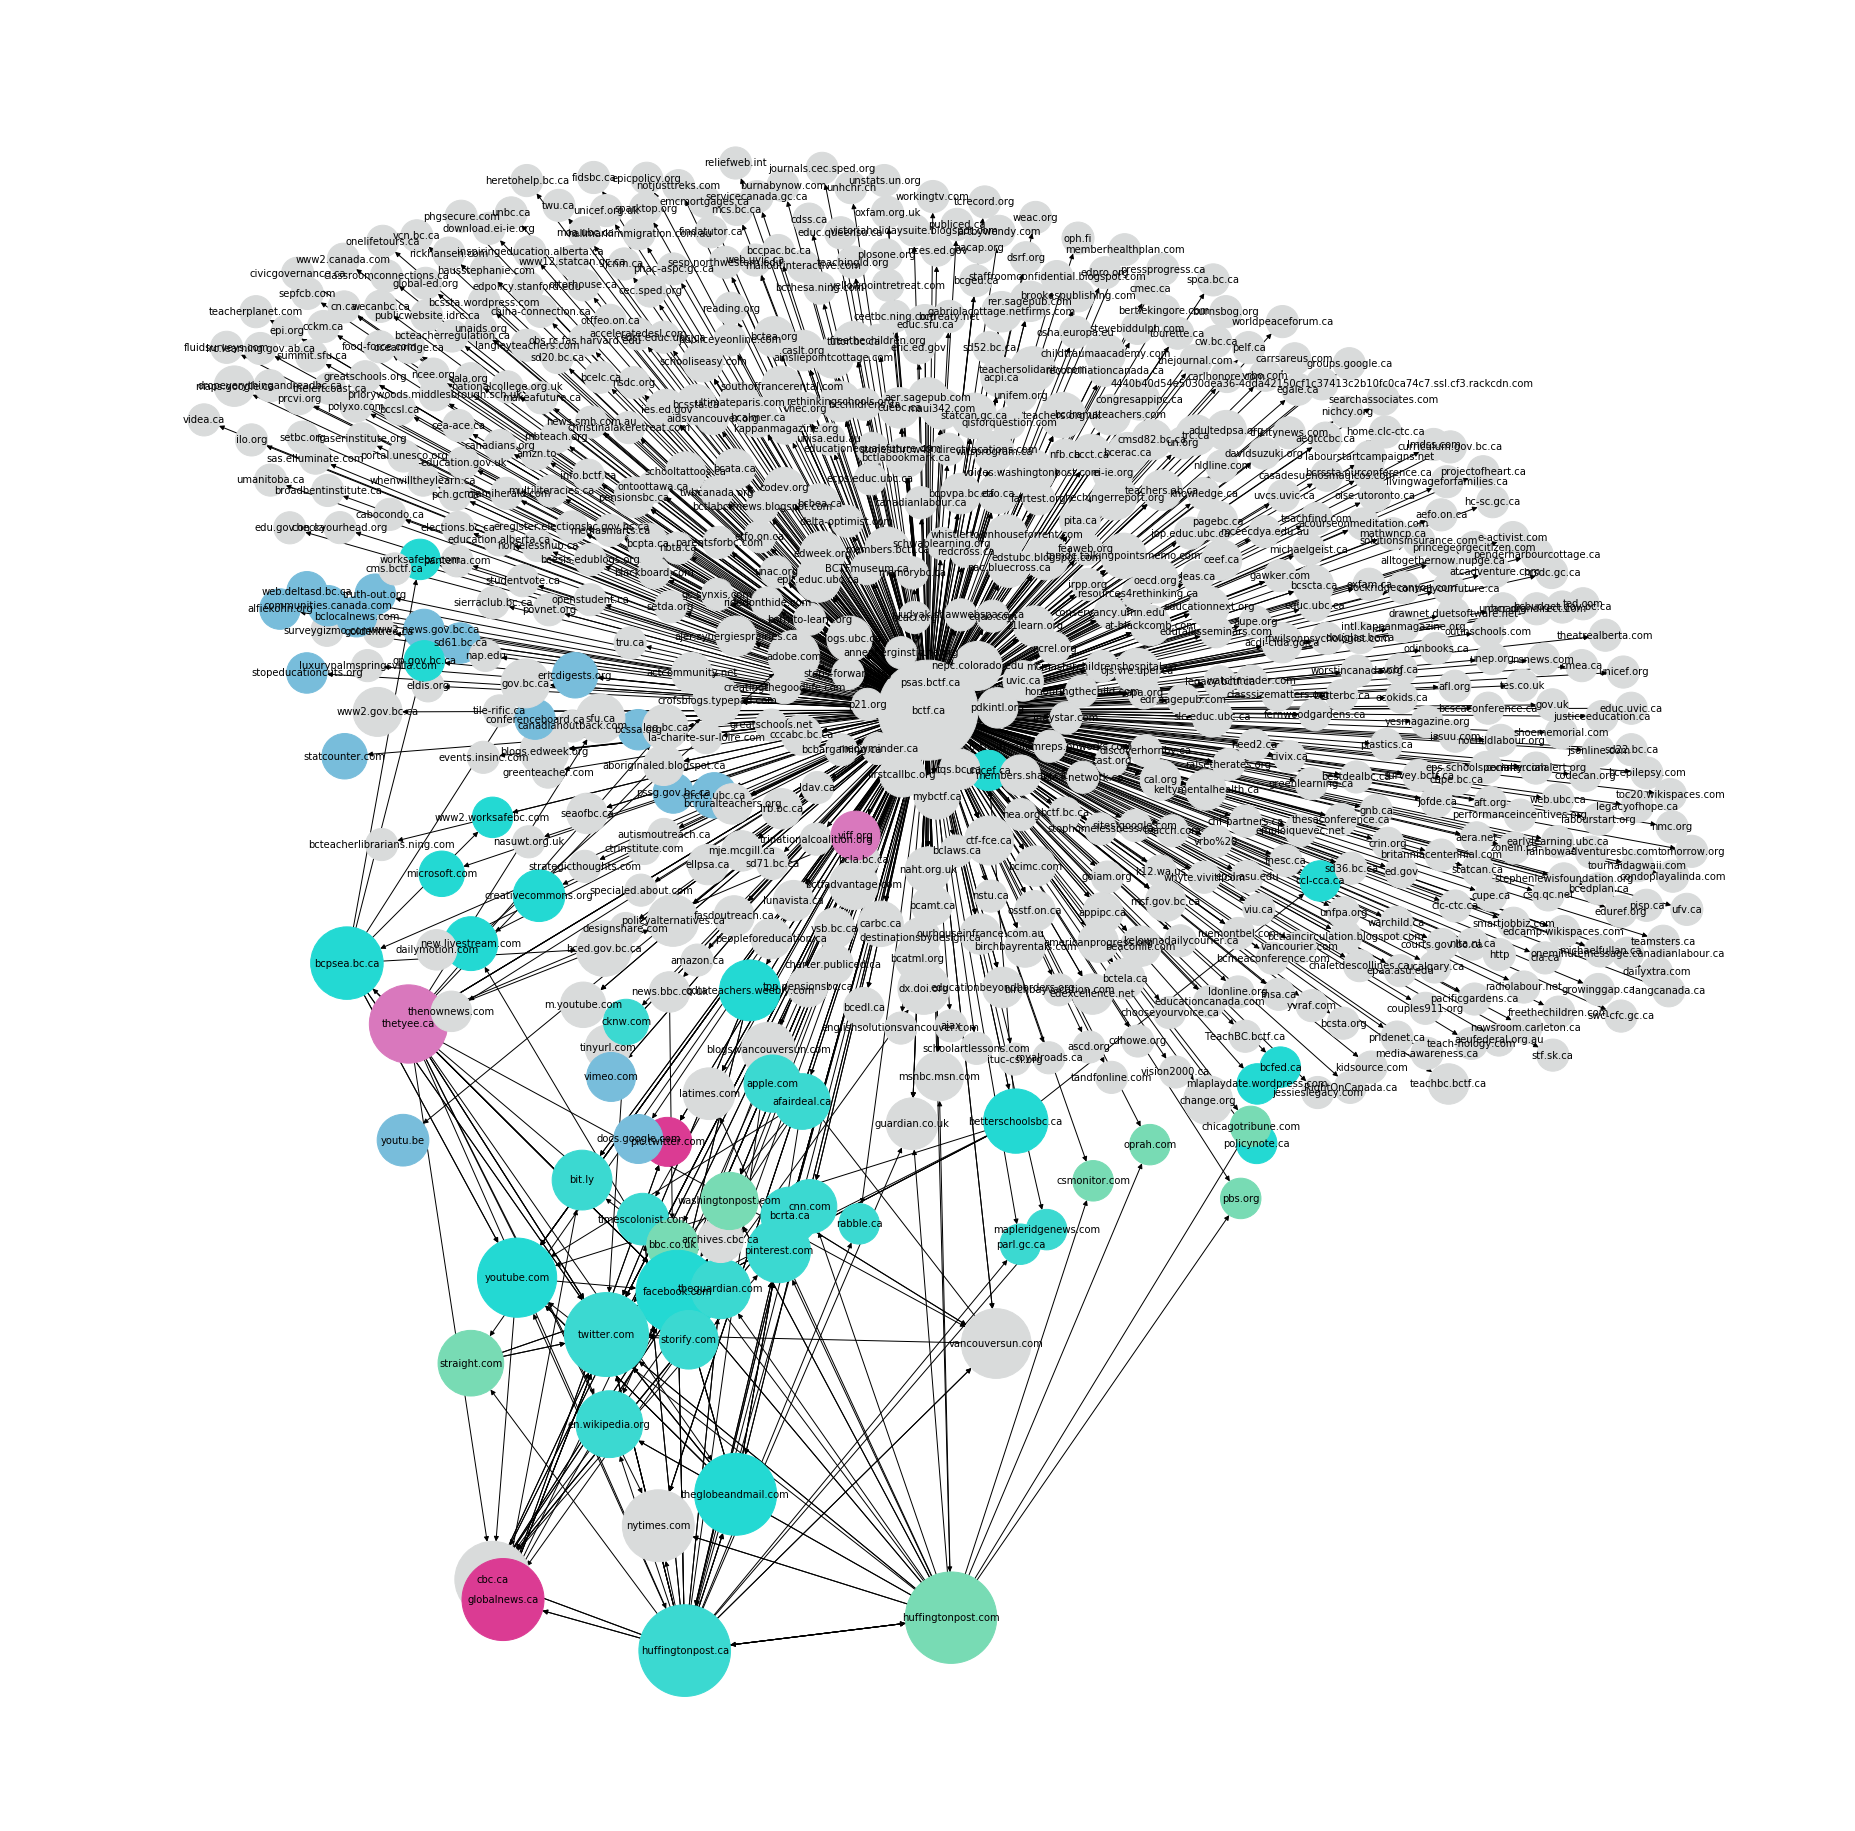

In [139]:
# Ego network for a particular node.

largest_node = sorted(graph.nodes('Degree'), 
                      key=lambda s: s[1], 
                      reverse=True)[NETWORK_EGO_NODE_ORDINAL][0] # [1][0] is second largest, etc.
node = NETWORK_EGO_NODE_SPECIFIC if (NETWORK_EGO_NODE_SPECIFIC) else largest_node
neigh = graph.subgraph(graph.neighbors(node))

# Convert rgb values to between 0 & 1 and put them into a numpy array.

rgbs = zip([x[1]/255 for x in neigh.nodes('r')], 
           [x[1]/255 for x in neigh.nodes('g')], 
           [x[1]/255 for x in neigh.nodes('b')])
colormap = [np.array(x) for x in rgbs]

# Labels.

mapping = {x[0]: x[1] for x in neigh.nodes('label')}

# Use Archive Unleashed Clouds positions (saves on load time).

zippos = zip(neigh.nodes, [x[1] for x in neigh.nodes('x')], [x[1] for x in neigh.nodes('y')])
positions = {x[0]: np.array([x[1],x[2]]) for x in zippos}

# Node sizes based on degree.

size = np.array([x[1] * NETWORK_NODE_SIZE for x in neigh.nodes('size')])
nx.draw(neigh, pos=positions, show_labels=NETWORK_SHOW_LABELS, 
        labels=mapping, font_size=NETWORK_FONT_SIZE, 
        node_size=size, node_color=colormap)
plt.show()

# Bibliography
- Archives Unleashed Project. (2018). Archives Unleashed Toolkit (Version 0.17.0). Apache License, Version 2.0.
- Aric A. Hagberg, Daniel A. Schult and Pieter J. Swart, “Exploring network structure, dynamics, and function using NetworkX”, in Proceedings of the 7th Python in Science Conference (SciPy2008), Gäel Varoquaux, Travis Vaught, and Jarrod Millman (Eds), (Pasadena, CA USA), pp. 11–15, Aug 2008.
- Bird, Steven, Edward Loper and Ewan Klein (2009), *Natural Language Processing with Python*. O’Reilly Media Inc.
- University of Victoria Libraries, B.C. Teachers' Labour Dispute (2014), Archive-It Collection 4867, https://archive-it.org/collections/4867.